Loading Data

In [1]:
import pandas as pd

# Load CSV
df = pd.read_csv(f"E:\ML proj\Data\msme_MAHARASHTRA.csv")

# Check basic info
print(df.shape)
print(df.head())
print(df.info())
print(df['Activities'].head())

(19400, 9)
   LG_ST_Code        State  LG_DT_Code         District   Pincode  \
0          27  MAHARASHTRA         473       CHANDRAPUR  442502.0   
1          27  MAHARASHTRA         488        OSMANABAD  413504.0   
2          27  MAHARASHTRA         483  MUMBAI SUBURBAN  400101.0   
3          27  MAHARASHTRA         480         KOLHAPUR  416502.0   
4          27  MAHARASHTRA         486        NANDURBAR  425409.0   

  RegistrationDate             EnterpriseName  \
0       21/01/2021  ABDUL KADAR MAJEET SHEIKH   
1       21/01/2021       AAPULUCKY COLLECTION   
2       21/01/2021             MOMAI MATERIAL   
3       21/01/2021             SAFALYA CLINIC   
4       21/01/2021        SHEETAL ENTERPRISES   

                                CommunicationAddress  \
0  WARD NO 3, AARAMACHIN, USGAON, WARD NO 3, NAKO...   
1  -, TULJABHAVANI NAGAR, CHINCHPUR ROAD, -, BHOO...   
2  ROOM NO.6, HASAN AMIN CHAWL, RAM NAGAR, ROOM N...   
3  MAIN ROAD , KADGAON, MANCHEKAR BUILDING, MAIN ...   

Filter Columns

In [2]:
import json

def extract_activity_info(activity_str):
    try:
        if pd.isna(activity_str) or activity_str.strip() == "":
            return "", None
        activity_list = json.loads(activity_str)  # Use json.loads
        descriptions = [d.get('Description', '') for d in activity_list]
        nic_codes = [d.get('NIC5DigitId', '') for d in activity_list]
        return " ".join(descriptions), nic_codes[0] if nic_codes else None
    except:
        return "", None


# Apply extraction
df[['ActivityDescription', 'NIC5DigitId']] = df['Activities'].apply(lambda x: pd.Series(extract_activity_info(x)))

# Now keep only relevant columns
df = df[['EnterpriseName', 'ActivityDescription', 'NIC5DigitId']]

print(df.head())
print(df.info())

              EnterpriseName  \
0  ABDUL KADAR MAJEET SHEIKH   
1       AAPULUCKY COLLECTION   
2             MOMAI MATERIAL   
3             SAFALYA CLINIC   
4        SHEETAL ENTERPRISES   

                                 ActivityDescription NIC5DigitId  
0                             Transport via pipeline       49300  
1  Manufacture of all types of textile garments a...       14101  
2  Manufacture of wearing apparel made of leather...       14104  
3                                Hospital activities       86100  
4  Manufacture of furniture made of wood Manufact...       31001  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19400 entries, 0 to 19399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   EnterpriseName       19399 non-null  object
 1   ActivityDescription  19400 non-null  object
 2   NIC5DigitId          19367 non-null  object
dtypes: object(3)
memory usage: 454.8+ KB
None


Missing Values handling

In [3]:
print(df.isna().sum())
df = df.dropna(subset=['NIC5DigitId'])
df['EnterpriseName'] = df['EnterpriseName'].fillna("")
df['ActivityDescription'] = df['ActivityDescription'].fillna("")
print(f"\n\nAfter Cleaning: \n{df.isna().sum()}")

EnterpriseName          1
ActivityDescription     0
NIC5DigitId            33
dtype: int64


After Cleaning: 
EnterpriseName         0
ActivityDescription    0
NIC5DigitId            0
dtype: int64


Merge Text Features

In [4]:
df['Text'] = df['EnterpriseName'] + " " + df['ActivityDescription']
df = df[['Text', 'NIC5DigitId']]


Clean & Normalize

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\d+', ' ', text)  # remove numbers
    text = re.sub(r'[^\w\s]', ' ', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text)  # remove extra whitespace
    # Lemmatize
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['CleanText'] = df['Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Encode Target Labels

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Label'] = le.fit_transform(df['NIC5DigitId'])

# Save mapping for inference
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))


In [7]:
class_counts = df['Label'].value_counts()
rare_classes = class_counts[class_counts < 10].index
df = df[~df['Label'].isin(rare_classes)]

Split Data

In [8]:
from sklearn.model_selection import train_test_split

X = df['CleanText']
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Vectorization

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)


c:\Users\shrey\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error
import numpy as np

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print("Logistic Regression:")
print(f"Accuracy: {acc_lr:.4f}, F1-score: {f1_lr:.4f}, MSE: {mse_lr:.4f}, MAE: {mae_lr:.4f}, RMSE: {rmse_lr:.4f}")


Logistic Regression:
Accuracy: 0.9176, F1-score: 0.9119, MSE: 5954.1907, MAE: 14.1267, RMSE: 77.1634


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print("Random Forest:")
print(f"Accuracy: {acc_rf:.4f}, F1-score: {f1_rf:.4f}, MSE: {mse_rf:.4f}, MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}")


Random Forest:
Accuracy: 0.9340, F1-score: 0.9303, MSE: 5365.4493, MAE: 12.4885, RMSE: 73.2492


In [ ]:
# Train SVM
model = SVC(kernel='rbf', C=10.0, probability=True, random_state=42)
model.fit(X_train_scaled, y_train)
# Predict
y_pred = model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)

# Metrics
cm = confusion_matrix(y_val, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_pred, labels=[0,1,2])

# Accuracy
accuracy = accuracy_score(y_val, y_pred)

# Per-class metrics
report = classification_report(y_val, y_pred, target_names=['Low', 'Medium', 'High'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Print
print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"Accuracy: {accuracy:.4f}")
print("\nPer-Class Metrics:")
print(report_df.round(4)[['precision', 'recall', 'f1-score']].iloc[:3])
print("\nOverall:")
print(f"Weighted Avg F1: {report['weighted avg']['f1-score']:.4f}")
print(f"Macro Avg F1:    {report['macro avg']['f1-score']:.4f}")
print("="*60)


EVALUATION METRICS
Accuracy: 0.9533

Per-Class Metrics:
        precision  recall  f1-score
Low        0.9444  1.0000    0.9714
Medium     1.0000  0.9216    0.9592
High       0.9808  1.0000    0.9903

Overall:
Weighted Avg F1: 0.9736
Macro Avg F1:    0.9736


C:\Users\shrey\AppData\Local\Temp\ipykernel_13032\2534013557.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature',


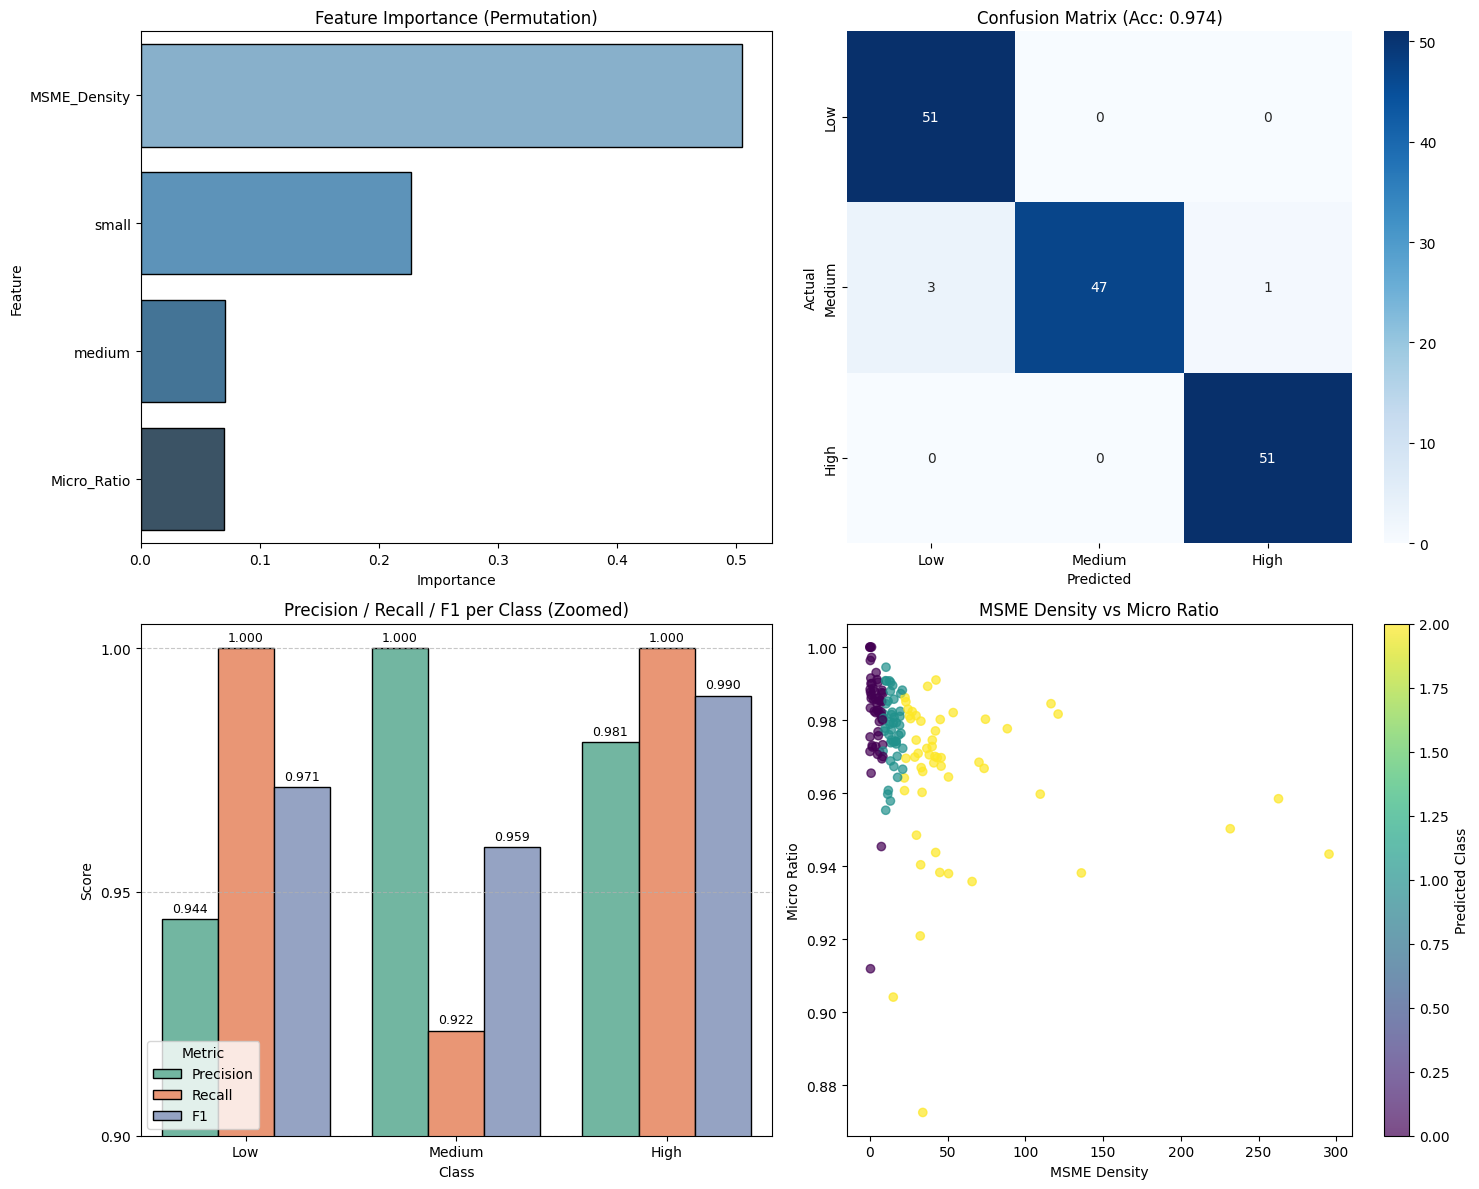

Feature Importance (Permutation):
        feature  importance
0  MSME_Density      0.5046
2         small      0.2268
3        medium      0.0712
1   Micro_Ratio      0.0699


In [10]:
# Setup figure with 2x2 grid
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# --- 1. Feature Importance (Permutation) ---
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    model, X_val_scaled, y_val,
    n_repeats=10, random_state=42, scoring='accuracy'
)

importance_df = pd.DataFrame({
    'feature': features,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df, x='importance', y='feature', 
            ax=axes[0,0], palette='Blues_d', edgecolor='black')
axes[0,0].set_title('Feature Importance (Permutation)')
axes[0,0].set_xlabel('Importance')
axes[0,0].set_ylabel('Feature')

# --- 2. Confusion Matrix ---
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low','Medium','High'],
            yticklabels=['Low','Medium','High'], ax=axes[0,1])
axes[0,1].set_title(f'Confusion Matrix (Acc: {accuracy:.3f})')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# --- 3. Precision / Recall / F1 — ZOOMED ---
metrics_df = pd.DataFrame({
    'Class': ['Low', 'Medium', 'High'],
    'Precision': prec, 'Recall': rec, 'F1': f1
}).melt(id_vars='Class', var_name='Metric', value_name='Score')  # Fixed: value_name

sns.barplot(data=metrics_df, x='Class', y='Score', hue='Metric',
            ax=axes[1,0], palette='Set2', edgecolor='black')
axes[1,0].set_ylim(0.90, 1.005)
axes[1,0].set_yticks([0.90, 0.95, 1.00])
axes[1,0].set_title('Precision / Recall / F1 per Class (Zoomed)')
axes[1,0].legend(title='Metric', loc='lower left')
axes[1,0].grid(True, axis='y', linestyle='--', alpha=0.7)

for c in axes[1,0].containers:
    axes[1,0].bar_label(c, fmt='%.3f', fontsize=9, padding=3)

# --- 4. Density vs Ratio ---
val_df = X_val.copy()
val_df['Predicted'] = y_pred
scatter = axes[1,1].scatter(val_df['MSME_Density'], val_df['Micro_Ratio'],
                           c=val_df['Predicted'], cmap='viridis', alpha=0.7)
axes[1,1].set_title('MSME Density vs Micro Ratio')
axes[1,1].set_xlabel('MSME Density')
axes[1,1].set_ylabel('Micro Ratio')
plt.colorbar(scatter, ax=axes[1,1], label='Predicted Class')

# Final layout & save
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_visualizations.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print feature importance
print("Feature Importance (Permutation):")
print(importance_df.round(4))

In [13]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=5000)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)

print("SVM:")
print(f"Accuracy: {acc_svm:.4f}, F1-score: {f1_svm:.4f}, MSE: {mse_svm:.4f}, MAE: {mae_svm:.4f}, RMSE: {rmse_svm:.4f}")


SVM:
Accuracy: 0.9533, F1-score: 0.9529, MSE: 4715.1950, MAE: 10.3828, RMSE: 68.6673


In [14]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM"],
    "Accuracy": [acc_lr, acc_rf, acc_svm],
    "F1-score": [f1_lr, f1_rf, f1_svm],
    "MSE": [mse_lr, mse_rf, mse_svm],
    "MAE": [mae_lr, mae_rf, mae_svm],
    "RMSE": [rmse_lr, rmse_rf, rmse_svm]
})

print(results)


                 Model  Accuracy  F1-score          MSE        MAE       RMSE
0  Logistic Regression  0.917627  0.911912  5954.190668  14.126728  77.163402
1        Random Forest  0.934044  0.930309  5365.449309  12.488479  73.249227
2                  SVM  0.953341  0.952916  4715.194988  10.382776  68.667277
